In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
from sklearn import linear_model
from sklearn import preprocessing
import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import scatter_matrix
import json
import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa import ar_model
from statsmodels.tsa.arima_model import ARIMA

頭を整理して一から OSS を分析してみる
まず、サンプルを 1000 くらいとって ヒストグラムを作る
現在 [testing, mobile, backend] を対象にやっている
star とか ランキングに乗ってるやつとか、は手で入れるしかない
1197 をサンプルとして分析する
まずはヒストグラムから

In [3]:
def convert_datetime(name):
    json = pd.read_json('../data/oss_downloads/' + name + '_download.json')
    df_json = pd.DataFrame(json['downloads'])
    df = json_normalize(df_json['downloads'])
    df['day'] = pd.to_datetime(df['day'], infer_datetime_format=False)
    df.index = df['day']
    return df

def convert_stateofjsDf(category):
    json = pd.read_json('../data/assets/target_oss/' + category + '_stateofjs.json')
    df_json = pd.DataFrame(json)    
    name = df_json['id']
    satisfaction2019 = df_json['satisfaction'].map( lambda x: x[3]['percentage'])
    satisfaction2018 = df_json['satisfaction'].map( lambda x: x[2]['percentage'])
    df = pd.DataFrame({'name': name, "satisfaction_2019" : satisfaction2019, 'satisfaction_2018': satisfaction2018 })
    return df

def convert_star_week_datatime(name):
    name = name.split('/')
    fname = 'data/stars/' + name[0] +'_' + name[1] + '_stars.json'
    pkg = pd.read_json(fname)
    pkg = pd.Series(pd.to_datetime(pkg['staredAts'])).dt.date
    github_life = np.arange('2016-09-04', '2019-09-02', dtype='datetime64[D]')
    github_life = pd.Series(github_life, name='t').dt.date
    star_counts = []
    for d in github_life:
        count = pkg[pkg == d].count()
        star_counts.append(count)
    starsCount = pd.Series(star_counts, index=pd.date_range('2016-09-04', '2019-09-01'))
    return round(starsCount.resample(rule='W').mean())

def convert_week_datetime(name):
    df = convert_datetime(name)
    df_w = round(df.resample(rule="W").mean())
    return df_w

def convert_ts(name):
    df_w = convert_week_datetime(name)
    ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
    return ts

In [61]:
# ダウンロード数を算出する
# names =  pd.read_json('../data/assets/target_oss/names.json');
# for name in names['oss']:
# #     print(name)
#     try:
#         json = convert_datetime(name)
#         data = json['downloads']['2019-09-01']
#         print(data)
#     except ValueError as e:
#         print(e)

In [4]:
names =  pd.read_json('../data/assets/target_oss/names.json');
download2019 = pd.read_json('../data/assets/target_oss/2019_download.json')

df = pd.DataFrame(download2019['2019_download'])
# df.hist()
# df.describe()

,2019_download
count,856.000000
mean,3.902092
std,2.855639
min,0.000000
25%,1.609438
50%,3.569433
75%,5.894391
max,12.114862


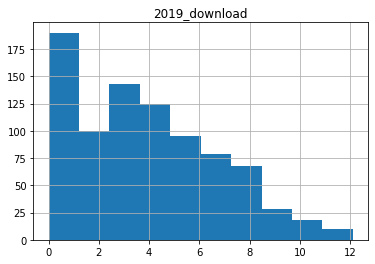

In [5]:
logdf = df.apply(np.log)
# logdf
logdf = logdf[np.isfinite(logdf['2019_download'])]
logdf.hist()
logdf.describe()

In [6]:
mobile = convert_stateofjsDf('mobile')
testing = convert_stateofjsDf('testing')
backend = convert_stateofjsDf('backend')

In [8]:
oss_satisfaction = pd.concat([mobile, testing, backend], ignore_index=True)
# oss_satisfaction

In [140]:
stateofjsname = [
    'electron',
    'react-native',
    'cordova',
    'ionic',
    'nwjs',
    'expo',
    'jest',
    'mocha',
    '@storybook::react',
    'cypress',
    'enzyme',
    'ava',
    'jasmine',
    'puppeteer',
    "express",
    'next',
    'koa',
    'meteor',
    'sails',
    '@feathersjs::feathers',
    'nuxt',
    'gatsby'
]
download2019 = []
download2018 = []
download2017 = []
grate2019 = []
grate2018 = []
trend2017 = []
trend2018 = []
trend2019 = []

for name in stateofjsname:
    json = convert_datetime(name)
    ts = convert_ts(name)
    trend = ts.trend[26:130]
    
    trend201709 = round(trend[1], 3)
    trend201809 = round(trend[52], 3)
    trend201909 = round(trend[103])

    download201709 = json['downloads']['2017-09-01']
    download201809 = json['downloads']['2018-09-01']
    download201909 = json['downloads']['2019-09-01']
    
    #  download より算出する場合
    #     grate201809 = round( json['downloads'].pct_change(freq='365D')['2018-09-01'], 3)
    #     grate201909 = round( json['downloads'].pct_change(freq='365D')['2019-09-01'], 3)

    grate201809 = round( (trend201809 / trend201709) , 3)
    grate201909 = round( (trend201909 / trend201809) , 3)
    
    trend2017.append(trend201709)
    trend2018.append(trend201809)
    trend2019.append(trend201909)
    
    download2017.append(download201709)
    download2018.append(download201809)
    download2019.append(download201909)
    
    grate2018.append(grate201809)
    grate2019.append(grate201909)

    
SeriesTrend2017 =  pd.Series(trend2017, name="trend_2017")
SeriesTrend2018 =  pd.Series(trend2018, name="trend_2018")
SeriesTrend2019 =  pd.Series(trend2019, name="trend_2019")

SeriesDownload2017 = pd.Series(download2017, name="download_2017")
SeriesDownload2018 = pd.Series(download2018, name="download_2018")
SeriesDownload2019 = pd.Series(download2019, name="download_2019")

SeriesGrate2019 = pd.Series(grate2019, name="grate_2019")
SeriesGrate2018 = pd.Series(grate2018, name="grate_2018")

df = pd.concat([
    oss_satisfaction,
    SeriesDownload2017,
    SeriesDownload2018,
    SeriesDownload2019, 
    SeriesTrend2017, 
    SeriesTrend2018, 
    SeriesTrend2019,
    SeriesGrate2019,
    SeriesGrate2018,
], axis=1)
df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars


,name,satisfaction_2019,satisfaction_2018,download_2017,download_2018,download_2019,trend_2017,trend_2018,trend_2019,grate_2019,grate_2018
0,electron,85.7,87.1,13749,8630,12401,8832.029,17852.385,29508.0,1.653,2.021
1,reactnative,82.1,83.8,24073,10327,12176,10134.808,22497.856,35333.0,1.571,2.220
2,cordova,28.0,34.3,23962,24008,7598,15184.875,19221.846,25891.0,1.347,1.266
3,ionic,40.6,51.5,14736,3510,3974,15264.779,14289.452,9155.0,0.641,0.936
4,nwjs,32.6,NaN,22,10,8,21.058,22.952,46.0,2.004,1.090
5,expo,73.8,NaN,4074,2798,3304,661.875,4043.837,6378.0,1.577,6.110
6,jest,96.4,96.5,82722,65517,180185,32089.644,163210.269,480968.0,2.947,5.086
7,mocha,77.7,82.3,213880,111353,153288,161977.317,240394.221,354632.0,1.475,1.484
8,storybook,91.9,89.1,9721,9607,19629,1559.923,24516.240,74621.0,3.044,15.716
9,cypress,93.2,NaN,151,3664,17249,14.404,6574.346,43684.0,6.645,456.425


In [12]:
# 2019 年度の散布図、まあ... 相関してそう..?
# 対数変換した方が見た目的に相関してて良さそう、とりあえず決定係数 R2 の要素は見るようにしよう
# x = df['satisfaction_2019'].values
# # y = df['download_2019'].values
# y = df['download_2019'].apply(np.log).values
# plt.plot(x, y, 'o')
# plt.show()

In [141]:
# 2019 と 2018 をがっちゃんこさせる
# 
#　増加率と前年の値について

name = np.concatenate([df['name'].values, df['name'].values], 0)
satisfaction = np.concatenate([df['satisfaction_2019'].values, df['satisfaction_2018'].values], 0)
satisfaction = np.array([ i * 0.01  for i in satisfaction ])
download = np.concatenate([df['download_2019'].values, df['download_2018'].values], 0)
# 対数変換
download  = np.array([np.log(i) for i in download])

rate_of_change = np.concatenate([df['grate_2019'].values, df['grate_2018'].values], 0)
# min - max スケーリング
# mscaler = preprocessing.MinMaxScaler()
# mscaler.fit(rate_of_change)
# rate_of_change = mscaler.transform(rate_of_change)

download_last_year = np.concatenate([df['download_2018'].values, df['download_2017'].values], 0)
# 対数変換
download_last_year  = np.array([np.log(i) for i in download_last_year])

trend = np.concatenate([df['trend_2019'].values, df['trend_2018'].values], 0)
# 対数変換
trend  = np.array([np.log(i) for i in trend])

stateofjs = pd.DataFrame(
    { "name": name,
      "satisfaction": satisfaction,
      "download": download,
      "rate_of_change": rate_of_change,
      "download_last_year": download_last_year,
      "trend": trend
    }
)

stateofjs = stateofjs.dropna().reset_index(drop=True)
stateofjs = stateofjs.drop(37)
stateofjs

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


,name,satisfaction,download,rate_of_change,download_last_year,trend
0,electron,0.857,9.425532,1.653,9.063000,10.292417
1,reactnative,0.821,9.407222,1.571,9.242517,10.472573
2,cordova,0.280,8.935640,1.347,10.086142,10.161651
3,ionic,0.406,8.287528,0.641,8.163371,9.122055
4,nwjs,0.326,2.079442,2.004,2.302585,3.828641
5,expo,0.738,8.102889,1.577,7.936660,8.760610
6,jest,0.964,12.101739,2.947,11.090065,13.083556
7,mocha,0.777,11.940074,1.475,11.620461,12.778836
8,storybook,0.919,9.884763,3.044,9.170247,11.220177
9,cypress,0.932,9.755509,6.645,8.206311,10.684737


In [128]:
# 単回帰分析

clf = linear_model.LinearRegression()
# X = stateofjs.loc[:, ['satisfaction']].apply(lambda x: x * 0.01).as_matrix()
# Y = stateofjs['download'].apply(np.log).as_matrix()
# 2019ダウンロード
# X = stateofjs.loc[:, ['download']].apply(np.log).as_matrix()
# 増加率
# X = stateofjs.loc[:, ['grate']].as_matrix()
# pre_download
X = stateofjs.loc[:, ['download']].apply(np.log).as_matrix()
Y = stateofjs['satisfaction'].apply(lambda x: x * 0.01).as_matrix()

clf.fit(X, Y)
print(clf.coef_)
 
# 切片 (誤差)
# print('切片', clf.intercept_)
 
# 決定係数
# print('決定係数', clf.score(X, Y))

# 散布図
# plt.scatter(X, Y)
 
# 回帰直線
# plt.plot(X, clf.predict(X))

# 結果の要約を出せる
# x_add_const = sm.add_constant(X)
# model_sm = sm.OLS(Y, x_add_const).fit()
# print(model_sm.summary())

[0.00369052]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [159]:
# 重回帰分析

# 説明変数
# 昨年のダウンロード数でやるとき
# exceptDf = stateofjs.drop('name', axis=1).drop('satisfaction', axis=1).drop('rate_of_change', axis=1)
# exceptDownload = exceptDf['download']
# exceptPreDownload = exceptDf['download_last_year']
# exceptDf = pd.DataFrame({"download": exceptDownload, "download_last_year": exceptPreDownload })

# 増加率でやるとき
exceptDf = stateofjs.drop('name', axis=1).drop('satisfaction', axis=1).drop('download_last_year', axis=1).drop('download', axis=1)
exceptDf = pd.DataFrame({"trend": exceptDf['trend'], "rate_of_change": exceptDf['rate_of_change'] })

X = exceptDf.as_matrix()
 
# 目的変数に "quality (品質スコア)" を利用
Y = stateofjs['satisfaction'].apply(lambda x: x * 0.01).as_matrix()
 
# 予測モデルを作成
clf.fit(X, Y)
 
# 偏回帰係数
print('偏回帰係数', pd.DataFrame({"Name":exceptDf.columns,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
 
# 切片 (誤差)
print('切片', clf.intercept_)

x_add_const = sm.add_constant(X)
model_sm = sm.OLS(Y, x_add_const).fit()
print(model_sm.summary())
result = model_sm
print('重決定R2:{:.4f}, 補正R2:{:.4f}, 有意F:{:.4f}, 切片:{:.4f}, 係数1:{:.4f}, P値1:{:.4f}, 係数2:{:.4f}, P値2:{:.4f}, ...'.format(
    result.rsquared, result.rsquared_adj, result.f_pvalue,
    result.params[0], result.params[1], result.pvalues[1], result.params[2], result.pvalues[2]))

exceptDf

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


偏回帰係数              Name  Coefficients
1  rate_of_change      0.000299
0           trend      0.000658
切片 -0.00027014932021824506
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     22.61
Date:                Sat, 28 Dec 2019   Prob (F-statistic):           5.69e-07
Time:                        17:27:09   Log-Likelihood:                 187.56
No. Observations:                  37   AIC:                            -369.1
Df Residuals:                      34   BIC:                            -364.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

,trend,rate_of_change
0,10.292417,1.653
1,10.472573,1.571
2,10.161651,1.347
3,9.122055,0.641
4,3.828641,2.004
5,8.760610,1.577
6,13.083556,2.947
7,12.778836,1.475
8,11.220177,3.044
9,10.684737,6.645


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


偏回帰係数 [0.00065771 0.00029942]
切片 -0.00027014932021824506
決定係数 0.570805469599648


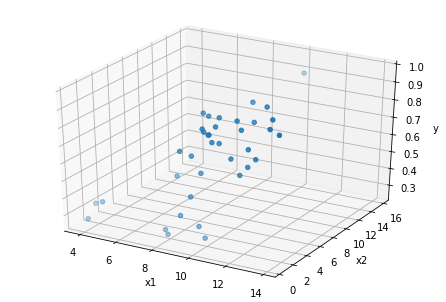

In [147]:
y = stateofjs['satisfaction'].as_matrix()
x1 = exceptDf['trend'].as_matrix()
# x2 = exceptDf['download_last_year'].as_matrix()
x2 = exceptDf['rate_of_change'].as_matrix()


model_lr = linear_model.LinearRegression()
model_lr.fit(X, Y)

fig=plt.figure()
ax=Axes3D(fig)

ax.scatter3D(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")

# mesh_x1 = np.arange(x1.min()[0], x1.max()[0], (x1.max()[0]-x1.min()[0])/20)
# mesh_x2 = np.arange(x2.min()[0], x2.max()[0], (x2.max()[0]-x2.min()[0])/20)
# mesh_x1, mesh_x2 = np.meshgrid(mesh_x1, mesh_x2)
# mesh_y = model_lr.coef_[0][0] * mesh_x1 + model_lr.coef_[0][1] * mesh_x2 + model_lr.intercept_[0]
# ax.plot_wireframe(mesh_x1, mesh_x2, mesh_y)
# plt.show()

print('偏回帰係数', model_lr.coef_)
print('切片', model_lr.intercept_)
print('決定係数', model_lr.score(X, Y))

<class 'seaborn.axisgrid.PairGrid'>


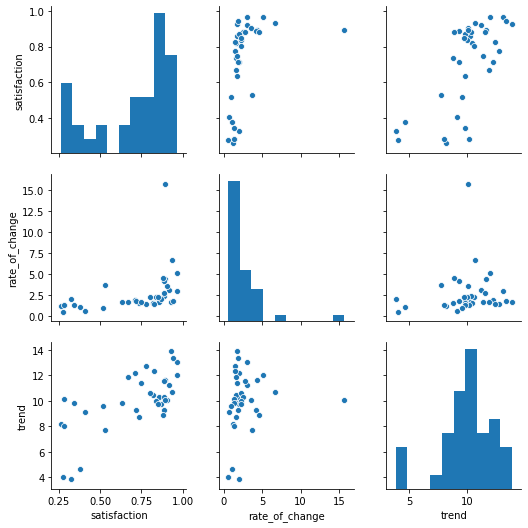

In [153]:
# TODO: 重回帰分析についてさらに考察を深める
# https://qiita.com/karaage0703/items/f38d18afc1569fcc0418
# scatter_matrix(stateofjs.T)
targetdf = stateofjs.drop('download_last_year', axis=1).drop('download', axis=1)


<class 'seaborn.axisgrid.PairGrid'>


,satisfaction,rate_of_change,download_trend
satisfaction,1.000000,0.400178,0.682119
rate_of_change,0.400178,1.000000,0.113530
download_trend,0.682119,0.113530,1.000000


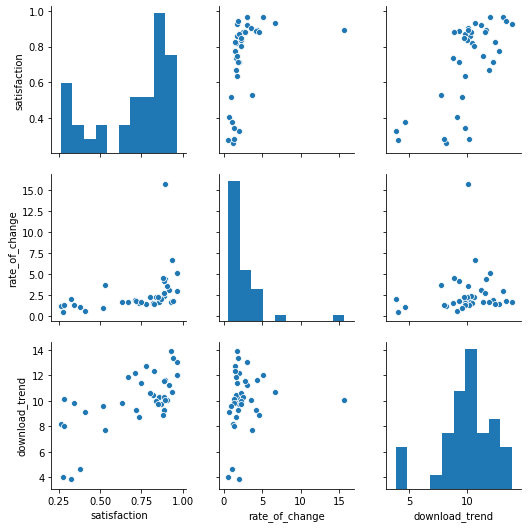

In [157]:
targetdf = targetdf.rename(columns={'trend': 'download_trend'})
pg = sns.pairplot(targetdf)
print(type(pg))
targetdf.corr()